In [1]:
import pandas as pd
import numpy as np
import json
from os import listdir
from os.path import isfile, join
from PIL import Image
import tifffile
from matplotlib.path import Path
import matplotlib.pyplot as plt

In [23]:
sample = "../input/hubmap-kidney-segmentation/sample_submission.csv"
prediction = "../submission.csv"
evalFile = "../input/hubmap-kidney-segmentation/train.csv"
testDir = "../input/hubmap-kidney-segmentation/test/"

# def get_num_pixels(filepath):
#     width, height = Image.open(filepath).size
#     return width*height

# print (get_num_pixels(testDir + "26dc41664.tiff"))

In [22]:
# Prediction Conversion Functions
def getPixels(start, count):
    if (type(start) == type("")):
        start_m = int(start)
        return np.arange(start_m, start_m + int(count)) 
    return np.arange(start, start + count)

def connect2(ends):
    d0, d1 = np.diff(ends, axis=0)[0]
    
    try:
        if np.abs(d0) > np.abs(d1): 
            return np.c_[np.arange(ends[0, 0], ends[1,0] + np.sign(d0), np.sign(d0), dtype=np.int32),
                         np.arange(ends[0, 1] * np.abs(d0) + np.abs(d0)//2,
                                   ends[0, 1] * np.abs(d0) + np.abs(d0)//2 + (np.abs(d0)+1) * d1, d1, dtype=np.int32) // np.abs(d0)]
        else:
            return np.c_[np.arange(ends[0, 0] * np.abs(d1) + np.abs(d1)//2,
                                   ends[0, 0] * np.abs(d1) + np.abs(d1)//2 + (np.abs(d1)+1) * d0, d0, dtype=np.int32) // np.abs(d1),
                         np.arange(ends[0, 1], ends[1,1] + np.sign(d1), np.sign(d1), dtype=np.int32)]
    except:
        print(ends)
def interpPixelList(li):
    res = []
    li_t = []
    
    #Edge case check
    if (len(li) <= 1):
        return li
        
    for i in range(0, len(li) - 1):
        #Get the index point, and the one after
        pts = []
        a = li[i]
        b = li[i+1]
        if (a[0] == b[0]):
            tmp = np.arange(a[0], b[0], 1).tolist()
            pts = np.array([(np.ones(len(tmp)) * a[0]).tolist(), tmp]).T.tolist()
        elif (a[1] == b[1]):
            tmp = np.arange(a[1], b[1], 1).tolist()
            pts = np.array([(np.ones(len(tmp)) * a[1]).tolist(), tmp]).T.tolist()
        else:
            pts = connect2(np.array([a, b])).tolist()
        
        res.extend(pts)
#     for indx, axis in enumerate(li_t):
#         res.append([])
#         #interpolate these points
#         for i in range(0, len(axis) - 1):
#             #Get the index point, and the one after
#             a = axis[i]
#             b = axis[i+1]
#             print("{} {}".format(a, b))
            
    return res
    
def convertPixelList(li):
    res = []
    # now convert each pixel set
    for item in li:
        pixels = getPixels(*item)
        res.extend(pixels)
    return res
def convertPixelLine(string):
    i=iter(string.split(' '))                # for the nth case    
    li = list(map(" ".join,zip(i,i)))
    
    res = []
    # now convert each pixel set
    for item in li:
        pixels = getPixels(*(item.split(" ")))
        res.extend(pixels)
    return res
# print(getPixels(1,3))

# print(convertPixelLine("1 3 10 5"))
# print(interpPixelList([[10, 11], [20, 21], [30, 31], [40, 41]]))
# print(connect2(np.array([[10, 11], [20, 17]])))
print(interpPixelList([[10, 20], [15, 20]]))

[]


In [27]:
df_pred  = pd.read_csv(prediction, index_col=0)
print(df_pred)

                                                   predicted
id                                                          
b9a3865fc  61146687 24 61177969 46 61209258 58 61240548 6...
b2dc8411c  57226435 181 57227387 72 57241279 181 57242231...
26dc41664  246214590 19 246252740 37 246290890 54 2463290...
c68fe75ea  22196107 167 22222947 167 22249786 169 2227662...
afa5e8098  70732250 305 70769050 305 70805850 305 7084265...


In [25]:
df_truth = pd.read_csv(evalFile, index_col=0)
print(df_truth)

                                                    encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
0486052bb  101676003 6 101701785 8 101727568 9 101753351 ...
e79de561c  7464094 14 7480273 41 7496453 67 7512632 82 75...
095bf7a1f  113430380 22 113468538 67 113506697 111 113544...
54f2eec69  124601765 36 124632133 109 124662536 147 12469...
1e2425f28  49453112 7 49479881 22 49506657 31 49533433 40...


In [5]:
#Evaluation Conversion Functions
def getRawPixels(coordinates, sze):
    res = []
    for coord in coordinates:
        val = (coord[0] * sze[0]) + (coord[1] * sze[1])
        res.append(val)
    return res

# print(getRawPixels([[4028, 23672]]))

In [11]:
#  
onlyfiles = [f for f in listdir(testDir) if isfile(join(testDir, f)) and join(testDir, f)[-4:] == "json"]
print(onlyfiles)

#dictionary to hold values of coordinates
groundTruth = {}
coordinate_list = []

for file in onlyfiles:
    #reset coordinate list
    coordinate_list = []
    baseimage = tifffile.imread(join(testDir, file.split("-")[0] + ".tiff"))
    if len(baseimage.shape) > 3:
        shpe = [baseimage.shape[3], baseimage.shape[4]]
    else:
        shpe = baseimage.shape
        
    print ('original image shape',baseimage.shape)
    
    with open(join(testDir, file)) as f:
        name = file.split("-")[0]
#         print(name)
        groundTruth[name] = []
        j = json.load(f)
        for item in j:
            if (item["geometry"]["type"] == "Polygon"):
#                 print("Hello")
                coords = item["geometry"]["coordinates"]
                # NOTE this index might cause errors later
#                 raw_coords = convertPixelList(coords[0])
#                 raw_coords = interpPixelList(coords[0])
    
#                 x, y = np.meshgrid(np.arange(26840), np.arange(49780)) # make a canvas with coordinates
#                 x, y = x.flatten(), y.flatten()
#                 points = np.vstack((x,y)).T 

#                 p = Path(raw_coords) # make a polygon
#                 grid = p.contains_points(points)
#                 mask = grid.reshape(300,300) # now you have a mask with points inside a polygon
#                 plt.imshow(mask)
                groundTruth[name].append(coords[0])

['c68fe75ea-anatomical-structure.json', 'afa5e8098-anatomical-structure.json', 'b9a3865fc-anatomical-structure.json', 'b2dc8411c-anatomical-structure.json', '26dc41664-anatomical-structure.json']
original image shape (1, 1, 3, 26840, 49780)
original image shape (36800, 43780, 3)
original image shape (31295, 40429, 3)
original image shape (14844, 31262, 3)
original image shape (1, 1, 3, 38160, 42360)


In [ ]:
#Plot the ground truths
for item in groundTruth:
    pts = groundTruth[item]
    
    x, y = np.meshgrid(np.arange(26840), np.arange(49780)) # make a canvas with coordinates
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T 

    p = Path(pts) # make a polygon
    grid = p.contains_points(points)
    mask = grid.reshape(300,300) # now you have a mask with points inside a polygon
    plt.imshow(mask)

In [28]:
#Evaluate
sum = 0.0
for item in groundTruth:
    dice_val = 0.0
    pred_str = df_pred["predicted"][item]
    pred_coords = convertPixelLine(pred_str)
    X_ABS = len(pred_coords)
    
    eval_coords = df_truth["encoding"][item]
    Y_ABS = len(eval_coords)
    print("{} {}".format(X_ABS, Y_ABS))
    
    X = set(pred_coords)
    Y = set(eval_coords)
    
    numerator = 2 * len(X.intersection(Y))
    print("Numerator: {}".format(numerator))
    
    dice_val = numerator / (X_ABS + Y_ABS)
    print("Dice: {}".format( dice_val ))
    sum = dice_val

print(sum / len(groundTruth))
    

KeyError: 'c68fe75ea'

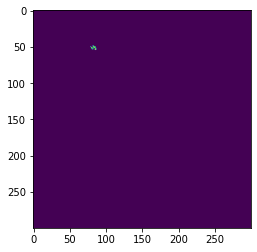

In [51]:
from matplotlib.path import Path
import matplotlib.pyplot as plt

tupVerts=[(86, 52), (85, 52), (81, 53), (80, 52), (79, 48), (81, 49), (86, 53),
 (85, 51), (82, 54), (84, 54), (83, 49), (81, 52), (80, 50), (81, 48),
 (85, 50), (86, 54), (85, 54), (80, 48), (79, 50), (85, 49), (80, 51),
 (85, 53), (82, 49), (83, 54), (82, 53), (84, 49), (79, 49)]


x, y = np.meshgrid(np.arange(300), np.arange(300)) # make a canvas with coordinates
x, y = x.flatten(), y.flatten()
points = np.vstack((x,y)).T 

p = Path(tupVerts) # make a polygon
grid = p.contains_points(points)
mask = grid.reshape(300,300) # now you have a mask with points inside a polygon
plt.imshow(mask)

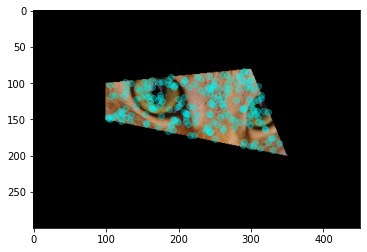

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

import skimage.data

# path vertex coordinates
vertices = np.asarray([(100, 100),
                       (300,  80),
                       (350, 200),
                       ( 100, 150)])

# create dummy image
img = skimage.data.chelsea()

# from vertices to a matplotlib path
path = Path(vertices)
xmin, ymin, xmax, ymax = np.asarray(path.get_extents(), dtype=int).ravel()

# create a mesh grid for the whole image, you could also limit the
# grid to the extents above, I'm creating a full grid for the plot below
x, y = np.mgrid[:img.shape[1], :img.shape[0]]
# mesh grid to a list of points
points = np.vstack((x.ravel(), y.ravel())).T

# select points included in the path
mask = path.contains_points(points)
path_points = points[np.where(mask)]

# reshape mask for display
img_mask = mask.reshape(x.shape).T

# now lets plot something to convince ourselves everything works
fig, ax = plt.subplots()

# masked image
ax.imshow(img * img_mask[..., None])
# a random sample from path_points
idx = np.random.choice(np.arange(path_points.shape[0]), 200)
ax.scatter(path_points[idx, 0], path_points[idx, 1], alpha=0.3, color='cyan')

In [29]:
def mask2rle(img):
    '''
    Efficient implementation of mask2rle, from @paulorzp
    https://www.kaggle.com/xhlulu/efficient-mask2rle
    https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
    --
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.pad(pixels, ((1, 1), ))
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

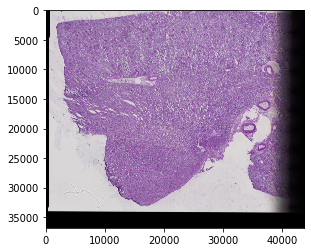

ValueError: operands could not be broadcast together with shapes (1260971942,) (1260971943,) (1260971942,) 

In [30]:
import numpy as np
import cv2
import tifffile
import matplotlib.pyplot as plt

name = "afa5e8098"
img = tifffile.imread(join(testDir, name + ".tiff"))
plt.imshow(img)
plt.show()

print(mask2rle(img))

for i in range(len(groundTruth[name])):
    pts = np.array(groundTruth[name][i])
    print(groundTruth[name][i])

    mask = np.zeros((img.shape[0], img.shape[1]))

    cv2.fillConvexPoly(mask, pts, 1)
    mask = mask.astype(np.bool)

    out = np.zeros_like(img)
    out[mask] = img[mask]

    plt.imshow(out)
    plt.show()

In [20]:
def get_mask(id_):
    train_csv = pd.read_csv('../input/hubmap-kidney-segmentation/train.csv')
    image = tifffile.imread('../input/hubmap-kidney-segmentation/train/{}.tiff'.format(id_))
    mask_cod  = train_csv.loc[train_csv['id'] == id_]['encoding'].values[0]
    
    mask = np.zeros((image.shape[0]*image.shape[1]), dtype=np.uint8)
    
    rle_mask = mask_cod.split()
    positions = map(int, rle_mask[::2])
    lengths = map(int, rle_mask[1::2])
    for pos, le in zip(positions, lengths):
        mask[pos-1:pos+le-1] = 1
   
    mask = mask.reshape((image.shape[1], image.shape[0]))

    return image, mask.T

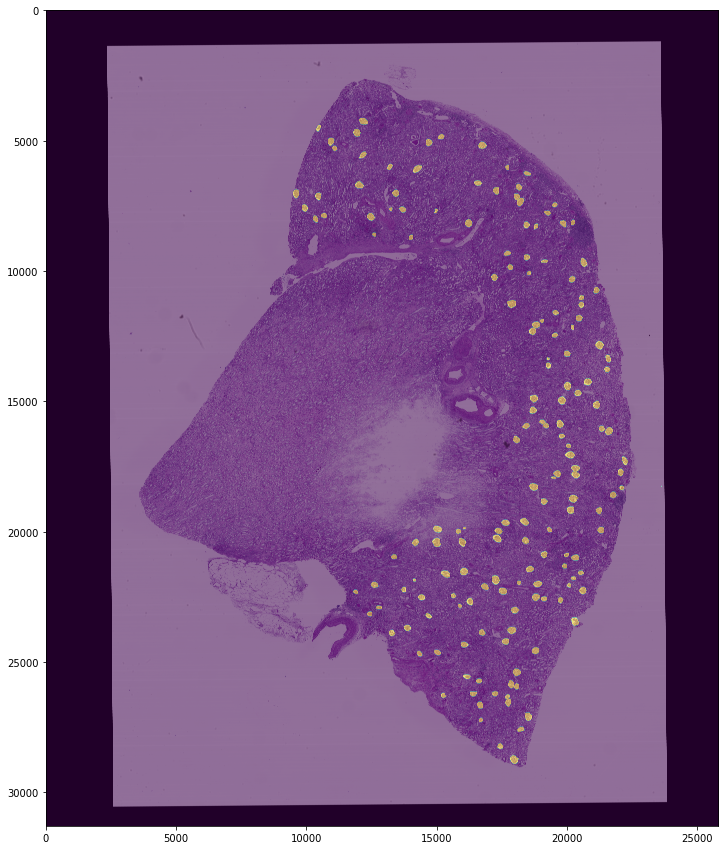

In [21]:


image, mask = get_mask('2f6ecfcdf')

plt.figure(figsize=(15,15))
plt.imshow(image)
plt.imshow(mask,alpha=0.5)
plt.show()